In [97]:
# imports
from operator import itemgetter
import random

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import inv
from sklearn.datasets import make_regression, make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from surprise import KNNWithZScore, SVD, Dataset, KNNBasic
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split as surprise_train_test_split

# set random state for reproducibility
kwargs = dict(random_state=42)

# Linear regression

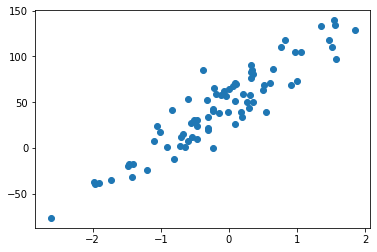

In [98]:
# create dataset
X, y = make_regression(n_samples=100, n_features=1, noise=20, bias=50, **kwargs)

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, **kwargs)

# plot training set
plt.scatter(X_train, y_train)

MSE: 416.80890612748107
MAE: 16.833319844418106


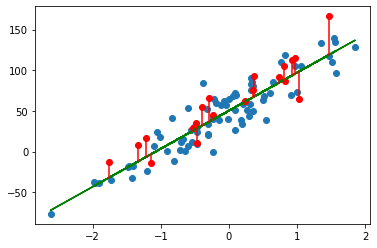

In [99]:
# fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# make predictions on test set
y_pred = lr.predict(X_test)

# plot training set, regression line, and errors on test set
plt.scatter(X_train, y_train)
plt.plot(X, lr.predict(X), color="green")
plt.scatter(X_test, y_test, color="red")
for i in range(len(X_test)):
    plt.plot([X_test[i]]*2, [y_test[i], y_pred[i]], color="red")
    
# calculate mean squared error and mean absolute error
for name, metric in zip(("MSE", "MAE"), (mean_squared_error, mean_absolute_error)):
    print(f"{name}: {metric(y_test, y_pred)}")

# Multiple regression

In [100]:
# create dataset with 2 features
X, y = make_regression(n_samples=100, n_features=2, noise=20, bias=50, **kwargs)

# fit linear regression model
lr = LinearRegression()
lr.fit(X, y)

# calculate intercept and coefficients "by hand"
X = np.c_[np.ones(X.shape[0]), X]
theta = inv(X.T.dot(X)).dot(X.T).dot(y)

# check that intercept and coefficients are equal
print(theta)
print(lr.intercept_, lr.coef_)

[50.43271617 84.26785337 74.15664645]
50.43271616892191 [84.26785337 74.15664645]


# Logistic regression

Accuracy: 0.87


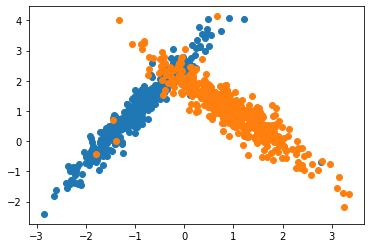

In [101]:
# create classification dataset
X, y = make_classification(n_samples=1000, n_classes=2, n_features=2, n_informative=2, n_redundant=0, flip_y=0.05, n_clusters_per_class=1, **kwargs)

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, **kwargs)

# visualize training dataset
for label in np.unique(y_train):
    mask = y_train == label
    plt.scatter(X_train[mask, 0], X_train[mask, 1])

# fit logistic regression model
logr = LogisticRegression(max_iter=1000, **kwargs)
logr.fit(X_train, y_train)

# evaluate model
y_pred = logr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Decision trees / train-validation-test split

Accuracy: 0.700625
Accuracy: 0.815625
Accuracy: 0.834


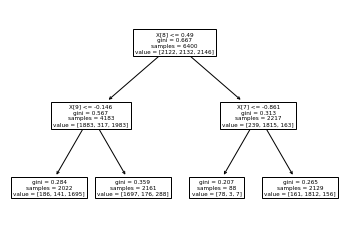

In [102]:
# create classification dataset with low signal-to-noise ratio
X, y = make_classification(n_samples=10000, n_classes=3, n_features=10, n_informative=2, n_redundant=8, flip_y=0.2, n_clusters_per_class=1, **kwargs)

# split into training, validation, and test set
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, **kwargs)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, shuffle=True, **kwargs)

# compare decision trees with max_depth None (no limit) and 2 on validation set and visualize tree
for max_depth in (None, 2):
    dt = DecisionTreeClassifier(max_depth=max_depth, **kwargs)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    print("Accuracy:", accuracy_score(y_val, y_pred))
    plot_tree(dt)
    
# max_depth 2 was better --> re-fit on training + validation set
dt = DecisionTreeClassifier(max_depth=2, **kwargs)
dt.fit(X_train_all, y_train_all)

# evaluate final model on test set
print("Accuracy:", accuracy_score(y_test, dt.predict(X_test)))

# Dimensionality reduction

In [103]:
# perform principal components analysis on training set
pca = PCA(**kwargs)
pca.fit(X_train_all)

# explained variance ratio: as expected, 2 components are enough
pca.explained_variance_ratio_.round(2)

array([0.62, 0.38, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [104]:
# transform training and test set predictors
# only use first 2 components
X_train_trans = pca.transform(X_train_all)[:, :2]
X_test_trans = pca.transform(X_test)[:, :2]

# fit decision tree on principal components
dt = DecisionTreeClassifier(max_depth=2, **kwargs)
dt.fit(X_train_trans, y_train_all)

# evaluate on test set
print("Accuracy:", accuracy_score(y_test, dt.predict(X_test_trans)))

Accuracy: 0.829


# Cross validation / bias-variance trade-off

In [105]:
# compare max_depth from 1 to 50 using 5-fold cross-validation on training (+ validation) set
gs = GridSearchCV(DecisionTreeClassifier(**kwargs), {"max_depth": range(1, 51)}, cv=KFold(5, shuffle=True, **kwargs), refit=True, return_train_score=True)
gs.fit(X_train_all, y_train_all)

# best configuration
gs.best_estimator_

DecisionTreeClassifier(max_depth=5, random_state=42)

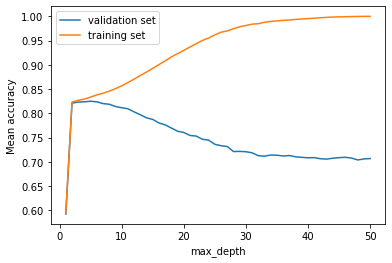

In [106]:
# plot training and validation accuracies for all values of max_depth
# overfitting is apparent: training accuracy increases, validation accuracy decreases
res = gs.cv_results_
plt.plot(res["param_max_depth"].data, res["mean_test_score"], label="validation set")
plt.plot(res["param_max_depth"].data, res["mean_train_score"], label="training set")
plt.xlabel("max_depth")
plt.ylabel("Mean accuracy")
plt.legend()

In [107]:
# evaluate model with best configuration on test set
y_pred = gs.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.837


# Recommender systems / model combination

In [108]:
# load dataset from surprise library
data = Dataset.load_builtin("ml-100k", prompt=False)

# split into training and test set
trainset, testset = surprise_train_test_split(data, test_size=0.2, shuffle=True, **kwargs)

# fit k-nearest-neighbors model
knn = KNNBasic(**kwargs)
knn.fit(trainset)

# evaluate model using root mean squared error
preds = knn.test(testset)
rmse(preds)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802


0.980150596704479

In [109]:
### DEFINE FUNCTIONS ###

# calculate mean squared error from actual ratings and predicted ratings
def mse(actuals, predictions):
    return ((actuals - predictions) ** 2).mean()

# compare combination weights and evaluate optimal weights estimate
def compare_weights(algos, trainset, test_ratings, ow_est=None):
    preds = []
    for algo in algos:
        algo.fit(trainset)
        preds.append([algo.predict(uid, iid).est for uid, iid, _, _ in test_ratings])
    preds = np.asarray(preds).T
    actuals = np.asarray([r[2] for r in test_ratings])
    ws = np.arange(0, 1.001, 0.01)
    mses = [mse(actuals, preds.dot((w, 1 - w))) for w in ws]
    plt.plot(ws, mses, label="Mean squared error")
    errors = actuals[:, np.newaxis] - preds
    cov_inv = inv(np.cov(errors, rowvar=False))
    i = np.ones(len(algos))
    ow = (cov_inv.dot(i) / i.T.dot(cov_inv).dot(i))[0]
    if ow_est is not None:
        plt.axvline(ow_est, color="red", linestyle="--", label="Estimated optimal weight")
    plt.axvline(ow, color="red", label="Optimal weight")
    plt.legend()
    plt.show()
    return ow

[80000, 10000, 10000]
Computing the msd similarity matrix...
Done computing similarity matrix.


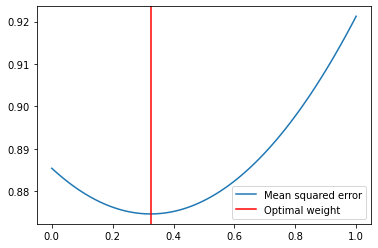

0.32677124573477573
Computing the msd similarity matrix...
Done computing similarity matrix.


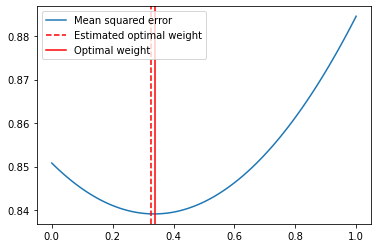

0.33763389907122243

In [110]:
# split ratings into training, validation, and test set (0.8, 0.1, 0.1)
ratings = sorted(data.raw_ratings, key=itemgetter(0, 1))
random.seed(99)
random.shuffle(ratings)
n_ratings = len(ratings)
n_train = round(0.8*n_ratings)
n_val = round(0.1*n_ratings)
train_ratings = ratings[:n_train]
val_ratings = ratings[n_train:(n_train + n_val)]
test_ratings = ratings[(n_train + n_val):]
print([len(r) for r in (train_ratings, val_ratings, test_ratings)])

# define collaborative filtering models: KNN and matrix factorization
algos = (KNNWithZScore(**kwargs), SVD(**kwargs))

# fit models on training set and calculate optimal weights on validation set
trainset = data.construct_trainset(train_ratings)
ow_est = compare_weights(algos, trainset, val_ratings)
print(ow_est)

# re-fit models on training + validation set and evaluate OW estimate on test set
trainset_all = data.construct_trainset(train_ratings + val_ratings)
compare_weights(algos, trainset_all, test_ratings, ow_est=ow_est)